### Dataset: https://www.kaggle.com/datasets/yuriikhilchenko/usl-ukrainian-sign-language-200x200?resource=download

### Problems:

- Letter Д;ї must be a video
- Some letters are missing after downloading zip file

- to do: fill in letters that can be filled in

In [2]:
### imports

import os
import copy
import random 

from PIL import Image
from IPython.display import display
import albumentations as A

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from torchvision import models
import torch

In [3]:
### First step - images to arrays
### TO DO: Google how to import images faster

path = r'USL_alphabet_train'
letters = {}
sizes = {}

# Iterate through dirs
for letter_dir in os.listdir(path):
    if 'undefined' in letter_dir:
        continue
        
    letters[letter_dir] = []
    image_index = 0
    for img in os.listdir(path + r'/' + letter_dir):
        img_path = path + r'/' + letter_dir + r'/' + img
        
        im = Image.open(img_path) 
        pix = np.array(im)
        
        if pix.shape not in sizes:
            sizes[pix.shape] = []
            
        sizes[pix.shape].append((letter_dir, image_index))
        image_index += 1
        
        letters[letter_dir].append(pix)

INITIAL_LETTERS_COPY = copy.deepcopy(letters)

In [39]:
len(sizes.keys())

275

Classes: 26
All images: 36856
(200, 200, 3)


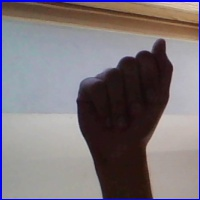

array([[[  0,   4, 253],
        [  0,   4, 252],
        [  2,   0, 244],
        ...,
        [  5,   0, 250],
        [  0,   3, 249],
        [  0,   4, 249]],

       [[  0,   3, 252],
        [  1,   3, 236],
        [ 15,   6, 209],
        ...,
        [  8,   2, 190],
        [  3,   4, 210],
        [  4,   9, 223]],

       [[  2,   0, 244],
        [ 15,   6, 211],
        [ 56,  41, 158],
        ...,
        [205, 193, 255],
        [188, 182, 255],
        [ 11,   8, 161]],

       ...,

       [[  8,   0, 248],
        [ 10,   5, 195],
        [147, 147, 219],
        ...,
        [155, 147, 170],
        [150, 146, 241],
        [ 13,  13, 143]],

       [[  2,   0, 252],
        [  5,   5, 215],
        [138, 138, 255],
        ...,
        [143, 139, 234],
        [135, 137, 255],
        [  6,  12, 168]],

       [[  0,   0, 254],
        [  3,   5, 227],
        [  9,   9, 167],
        ...,
        [ 15,  15, 145],
        [  6,  11, 167],
        [  6,  14, 183]]

In [50]:
# We have 26 different classes for different letters

def output_random_image(class_num):
    img = random.choice(letters[list(letters.keys())[class_num]])
    print(img.shape)
    display(Image.fromarray(img))
    
    return img
    
print("Classes: " + str(len(letters.keys())))
print("All images: " + str(sum([len(letter) for letter in letters.values()])))
# print("Unique sizes: " + str(set(x for x in sizes.keys() if x[-3] != 3)))

output_random_image(2)

In [5]:
### Problem 1: Data is in different dims

print("Unique sizes: ")
for key in sizes:
    print(key)

Unique sizes: 
(200, 200, 3)
(224, 224, 3)
(349, 450, 3)
(352, 448, 3)
(352, 449, 3)
(347, 450, 3)
(100, 100, 3)
(345, 451, 3)
(345, 457, 3)
(347, 462, 3)
(345, 460, 3)
(345, 464, 3)
(345, 461, 3)
(343, 459, 3)
(282, 421, 3)
(344, 458, 3)
(347, 469, 3)
(341, 462, 3)
(343, 462, 3)
(345, 463, 3)
(343, 460, 3)
(336, 459, 3)
(339, 463, 3)
(340, 464, 3)
(286, 416, 3)
(334, 462, 3)
(330, 465, 3)
(337, 465, 3)
(335, 465, 3)
(329, 459, 3)
(319, 466, 3)
(318, 466, 3)
(317, 474, 3)
(320, 466, 3)
(319, 472, 3)
(288, 442, 3)
(315, 474, 3)
(310, 475, 3)
(310, 488, 3)
(303, 454, 3)
(305, 456, 3)
(305, 460, 3)
(310, 493, 3)
(308, 499, 3)
(309, 500, 3)
(308, 456, 3)
(288, 443, 3)
(307, 451, 3)
(307, 494, 3)
(309, 501, 3)
(309, 503, 3)
(308, 503, 3)
(307, 495, 3)
(307, 500, 3)
(296, 480, 3)
(308, 497, 3)
(307, 504, 3)
(307, 498, 3)
(306, 452, 3)
(307, 455, 3)
(310, 499, 3)
(310, 497, 3)
(311, 498, 3)
(308, 461, 3)
(309, 463, 3)
(295, 473, 3)
(310, 492, 3)
(309, 489, 3)
(310, 458, 3)
(305, 451, 3)
(306,

In [6]:
### Problem 1 solving: Step 1
### Check if some arrays are NOT in RGB

not_rgb_sizes = [x for x in list(sizes.keys()) if x[-1] != 3 ]
print(not_rgb_sizes)

### Output count of such images
count = 0
for size in not_rgb_sizes:
    count += len(sizes[size])
print("Count of non rgb images: " + str(count))

### Q: Can we remove this images? 
letters_by_not_rgb_size = {}

for size in not_rgb_sizes:
    for image in sizes[size]:
        if image[0] not in letters_by_not_rgb_size:
            letters_by_not_rgb_size[image[0]] = 0
        
        letters_by_not_rgb_size[image[0]] += 1

for letter in letters_by_not_rgb_size:
    print(f"Letter: {letter}; Non rgb count is: {letters_by_not_rgb_size[letter]}; % by whole data is: {letters_by_not_rgb_size[letter] * 100 / len(letters[letter])} %")
    
# Answer: No, this data is 100% for some of the images

[(56, 100), (59, 100), (100, 100), (100, 56), (100, 55), (100, 75), (100, 68)]
Count of non rgb images: 4500
Letter: л. Л; Non rgb count is: 1500; % by whole data is: 100.0 %
Letter: л. М; Non rgb count is: 1500; % by whole data is: 100.0 %
Letter: л. Н; Non rgb count is: 1500; % by whole data is: 100.0 %


Letter: л. Н


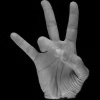

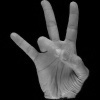

(100, 100, 3)


In [7]:
### Experimanting with one of the grayscale images

letter_, index_ = sizes[(100, 100)][0]
print("Letter: " + letter_)

pix = letters[letter_][index_]
pix_reshaped = pix.reshape((pix.shape[0], pix.shape[1], 1))

original = tf.constant(pix_reshaped)
converted = tf.image.grayscale_to_rgb(original).numpy()

display(Image.fromarray(pix))
display(Image.fromarray(converted))
print(converted.shape)

In [8]:
### Converting 1 channel to 3 channels

for size in not_rgb_sizes:
    for image in sizes[size]:
        letter_, index_ = image
        
        pix = letters[letter_][index_]
        pix_reshaped = pix.reshape((pix.shape[0], pix.shape[1], 1))

        original = tf.constant(pix_reshaped)
        converted = tf.image.grayscale_to_rgb(original).numpy()

        letters[letter_][index_] = converted
        
### Recalculating sizes

def calculate_sizes(letters_dict):
    sizes = {}

    # Iterate through dirs
    for letter in letters_dict:
        image_index = 0
        for img in letters_dict[letter]:
            if img.shape not in sizes:
                sizes[img.shape] = []

            sizes[img.shape].append((letter, image_index))
            image_index += 1

    return sizes

sizes = calculate_sizes(letters)
not_rgb_sizes = [x for x in list(sizes.keys()) if x[-1] != 3 ]
print(not_rgb_sizes)

### Good, we have 0 not rgb images

[]


In [9]:
letters.keys()

dict_keys(['л. I', 'л. Є', 'л. А', 'л. Б', 'л. В', 'л. Г', 'л. Е', 'л. Ж', 'л. З', 'л. И', 'л. К', 'л. Л', 'л. М', 'л. Н', 'л. О', 'л. П', 'л. Р', 'л. С', 'л. Т', 'л. У', 'л. Ф', 'л. Х', 'л. Ш', 'л. Ь', 'л. Ю', 'л. Я'])

In [10]:
### Problem 1 solving: Step 2

### Now, lets resize every data to the 200 x 200
### ASK: Methods of resizing image
### ASPECT RATIO DROPS

SIZE = (200, 200)

for letter in letters:
    for index, img in enumerate(letters[letter]):
        img = Image.fromarray(img)
        img = img.resize(SIZE)
        
        letters[letter][index] = np.array(img)
        
### Calculate sizes again
### Great! Now we have all sizes!
print(calculate_sizes(letters).keys())

dict_keys([(200, 200, 3)])


In [12]:
### Normalizing data: 
### Step 1: Removing duplicates

print("All images count BEFORE duplicates remove: " + str(sum([len(letter) for letter in letters.values()])))

for letter in letters:
    letters[letter] = np.unique(letters[letter], axis=0)

print("All images count AFTER duplicates remove: " + str(sum([len(letter) for letter in letters.values()])))
print(calculate_sizes(letters).keys())

All images count BEFORE duplicates remove: 36856
All images count AFTER duplicates remove: 36856
dict_keys([(200, 200, 3)])


[6000, 298, 3000, 3000, 381, 29, 3000, 293, 104, 293, 30, 1500, 1500, 1500, 286, 24, 32, 3000, 31, 3000, 292, 3000, 230, 3000, 33, 3000]


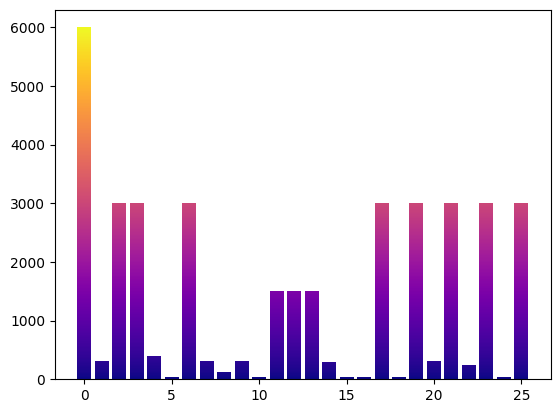

In [13]:
### Plot class distribution

classes = [i for i in range(len(list(letters.keys())))]
counts = [len(letters[letter]) for letter in letters]
final_count = []
for count in counts:
    if count >= 500:
        final_count.append(500)
    else:
        final_count.append(count)
bins = np.linspace(0, 26, 26)
print(counts)

def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower', aspect="auto", 
                  norm=plt.cm.colors.NoNorm(vmin=0,vmax=1), cmap=plt.get_cmap(cmap))
    
fig, ax = plt.subplots()
my_bar = ax.bar(classes, counts)
gradientbars(my_bar, counts, 'plasma')
plt.show()

# In General it is hell: Lower bound is 24 and upper bound is 6000

In [44]:
train_ds[0]

array([[[77.061    , 64.221    , 57.32     ],
        [78.061    , 65.221    , 58.32     ],
        [79.061    , 66.221    , 59.32     ],
        ...,
        [24.060997 , 11.221001 ,  4.3199997],
        [24.060997 , 11.221001 ,  4.3199997],
        [27.060997 , 14.221001 ,  7.3199997]],

       [[76.061    , 63.221    , 56.32     ],
        [75.061    , 62.221    , 55.32     ],
        [77.061    , 64.221    , 57.32     ],
        ...,
        [22.060997 ,  9.221001 ,  2.3199997],
        [24.060997 , 11.221001 ,  4.3199997],
        [26.060997 , 13.221001 ,  6.3199997]],

       [[75.061    , 62.221    , 55.32     ],
        [74.061    , 61.221    , 54.32     ],
        [75.061    , 62.221    , 55.32     ],
        ...,
        [22.060997 ,  9.221001 ,  2.3199997],
        [24.060997 , 11.221001 ,  4.3199997],
        [26.060997 , 13.221001 ,  6.3199997]],

       ...,

       [[95.061    , 82.221    , 75.32     ],
        [95.061    , 82.221    , 75.32     ],
        [95.061    , 8

(200, 200, 3)


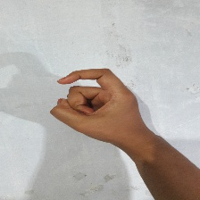

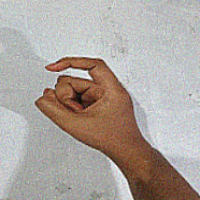

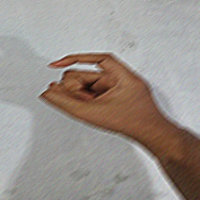

In [55]:
# Choosing one image and tricking it
img = output_random_image(1)
transform = A.Compose([
    A.MultiplicativeNoise(p=0.6),
    A.AdvancedBlur(p=0.6),
    A.GaussNoise(p=0.6),
    A.MotionBlur(p=0.6),
    A.Sharpen(p=0.6),
    A.Perspective(p=1, scale=(0.1, 0.1))
    
])

transformed = transform(image=img)
transformed_image = transformed["image"]

transformed2 = transform(image=img)
transformed_image2 = transformed2["image"]
def output_image_from_array(img):
    display(Image.fromarray(img))

output_image_from_array(transformed_image)
output_image_from_array(transformed_image2)

In [15]:
### Transforming images
rng = np.random.default_rng()

processed_letters = {}
counts = [len(letters[letter]) for letter in letters]

i = 0
for letter in letters:
    i += 1
    print(f'{i} classes has been processed out of //{len(letters)}') 
    print('Len is ' + str(len(letters[letter])))
    processed_letters[letter] = []
    if len(letters[letter]) >= 1500:
        # 1 Choose 1500 random images
        new_letters_array = rng.choice(letters[letter], size=1500, replace=False)
        processed_letters[letter] = new_letters_array
    else:
        coef = int((1500 - len(letters[letter])) / len(letters[letter]) + 0.5)
        coef = min([coef, 10])
        print('coef = ' + str(coef))
        
        for _ in range(coef):
            processed_letters[letter].extend([transform(image=img)['image'] for img in letters[letter]])
        processed_letters[letter] = np.array(processed_letters[letter])
            
        if len(processed_letters[letter]) > 1500:
            new_letters_array = np.random.choice(processed_letters[letter], size=1500, replace=False)
            processed_letters[letter] = new_letters_array

1 classes has been processed out of //26
Len is 6000
2 classes has been processed out of //26
Len is 298
coef = 4
3 classes has been processed out of //26
Len is 3000
4 classes has been processed out of //26
Len is 3000
5 classes has been processed out of //26
Len is 381
coef = 3
6 classes has been processed out of //26
Len is 29
coef = 10
7 classes has been processed out of //26
Len is 3000
8 classes has been processed out of //26
Len is 293
coef = 4
9 classes has been processed out of //26
Len is 104
coef = 10
10 classes has been processed out of //26
Len is 293
coef = 4
11 classes has been processed out of //26
Len is 30
coef = 10
12 classes has been processed out of //26
Len is 1500
13 classes has been processed out of //26
Len is 1500
14 classes has been processed out of //26
Len is 1500
15 classes has been processed out of //26
Len is 286
coef = 4
16 classes has been processed out of //26
Len is 24
coef = 10
17 classes has been processed out of //26
Len is 32
coef = 10
18 classes

[1500, 1192, 1500, 1500, 1143, 290, 1500, 1172, 1040, 1172, 300, 1500, 1500, 1500, 1144, 240, 320, 1500, 310, 1500, 1168, 1500, 1380, 1500, 330, 1500]


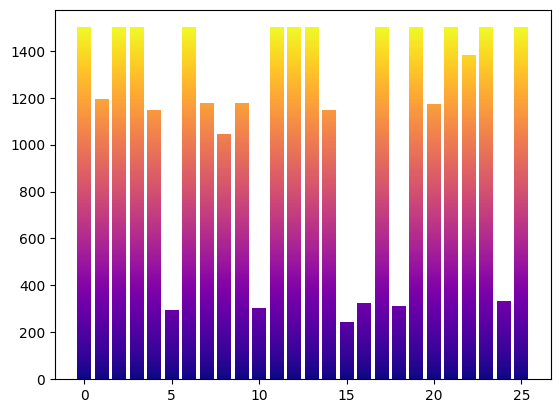

In [16]:
classes = [i for i in range(len(list(processed_letters.keys())))]
counts = [len(processed_letters[letter]) for letter in processed_letters]
    
bins = np.linspace(0, 26, 26)
print(counts)

fig, ax = plt.subplots()
my_bar = ax.bar(classes, counts)
gradientbars(my_bar, counts, 'plasma')
plt.show()


In [17]:
# Convert everything to grayscale

for letter in processed_letters:
    processed_letters[letter] = tf.image.rgb_to_grayscale(processed_letters[letter]).numpy()
    print(processed_letters[letter][0].shape)

(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)
(200, 200, 1)


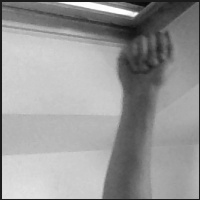

array([[[ 29],
        [ 30],
        [ 29],
        ...,
        [ 29],
        [ 28],
        [ 30]],

       [[ 29],
        [ 29],
        [ 29],
        ...,
        [ 29],
        [ 28],
        [ 26]],

       [[ 30],
        [ 31],
        [119],
        ...,
        [107],
        [110],
        [ 31]],

       ...,

       [[ 28],
        [ 27],
        [219],
        ...,
        [169],
        [176],
        [ 29]],

       [[ 28],
        [ 32],
        [214],
        ...,
        [172],
        [167],
        [ 28]],

       [[ 30],
        [ 27],
        [ 28],
        ...,
        [ 27],
        [ 31],
        [ 29]]], dtype=uint8)

In [18]:
def output_random_image(class_num):
    img = random.choice(processed_letters[list(processed_letters.keys())[class_num]])
    s = img
    img = img.reshape(200, 200)
    display(Image.fromarray(img, 'L'))
    
    return s

output_random_image(2)

In [19]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [20]:
classes = {}
indx = 1
for key in processed_letters:
    classes[key] = indx
    indx += 1
    
classes

{'л. I': 1,
 'л. Є': 2,
 'л. А': 3,
 'л. Б': 4,
 'л. В': 5,
 'л. Г': 6,
 'л. Е': 7,
 'л. Ж': 8,
 'л. З': 9,
 'л. И': 10,
 'л. К': 11,
 'л. Л': 12,
 'л. М': 13,
 'л. Н': 14,
 'л. О': 15,
 'л. П': 16,
 'л. Р': 17,
 'л. С': 18,
 'л. Т': 19,
 'л. У': 20,
 'л. Ф': 21,
 'л. Х': 22,
 'л. Ш': 23,
 'л. Ь': 24,
 'л. Ю': 25,
 'л. Я': 26}

In [21]:
X = None
y = None

for letter in processed_letters:
    if X is None:
        X = processed_letters[letter]
    else:
        X = np.concatenate((X, processed_letters[letter]))
    if y is None:
        y = np.array([classes[letter]] * len(processed_letters[letter]))
    else:
        y = np.concatenate((y, np.array([classes[letter]] * len(processed_letters[letter]))))

print(X.shape)
print(y.shape)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X, y = shuffle(X, y, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(29201, 200, 200, 1)
(29201,)


In [22]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [23]:
original = tf.constant(X_train)
converted = tf.image.grayscale_to_rgb(original).numpy()

train_ds = preprocess_input(converted) 

original = tf.constant(X_test)
converted = tf.image.grayscale_to_rgb(original).numpy()

test_ds = preprocess_input(converted)

In [59]:
train_ds

array([[[[  77.061    ,   64.221    ,   57.32     ],
         [  78.061    ,   65.221    ,   58.32     ],
         [  79.061    ,   66.221    ,   59.32     ],
         ...,
         [  24.060997 ,   11.221001 ,    4.3199997],
         [  24.060997 ,   11.221001 ,    4.3199997],
         [  27.060997 ,   14.221001 ,    7.3199997]],

        [[  76.061    ,   63.221    ,   56.32     ],
         [  75.061    ,   62.221    ,   55.32     ],
         [  77.061    ,   64.221    ,   57.32     ],
         ...,
         [  22.060997 ,    9.221001 ,    2.3199997],
         [  24.060997 ,   11.221001 ,    4.3199997],
         [  26.060997 ,   13.221001 ,    6.3199997]],

        [[  75.061    ,   62.221    ,   55.32     ],
         [  74.061    ,   61.221    ,   54.32     ],
         [  75.061    ,   62.221    ,   55.32     ],
         ...,
         [  22.060997 ,    9.221001 ,    2.3199997],
         [  24.060997 ,   11.221001 ,    4.3199997],
         [  26.060997 ,   13.221001 ,    6.3199997]],

In [24]:
train_labels = to_categorical(y_train, num_classes=27)
test_labels = to_categorical(y_test, num_classes=27)

In [32]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=converted[0].shape)
base_model.trainable = False ## Not trainable weights

In [33]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(40, activation='relu')
prediction_layer = layers.Dense(27, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [34]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_ds, train_labels, epochs=5, validation_split=0.2, batch_size=32, callbacks=[es])


Epoch 1/5
584/584 [==============================] - 3042s 5s/step - loss: 0.5857 - accuracy: 0.8416 - val_loss: 0.3170 - val_accuracy: 0.9268
Epoch 2/5
584/584 [==============================] - 3125s 5s/step - loss: 0.1377 - accuracy: 0.9639 - val_loss: 0.1758 - val_accuracy: 0.9602
Epoch 3/5
584/584 [==============================] - 3152s 5s/step - loss: 0.0882 - accuracy: 0.9797 - val_loss: 0.1451 - val_accuracy: 0.9645
Epoch 4/5
584/584 [==============================] - 3246s 6s/step - loss: 0.0464 - accuracy: 0.9877 - val_loss: 0.1150 - val_accuracy: 0.9732
Epoch 5/5
584/584 [==============================] - 3164s 5s/step - loss: 0.0654 - accuracy: 0.9857 - val_loss: 0.1025 - val_accuracy: 0.9788


In [172]:
history = model.fit(train_ds, train_labels, epochs=5, validation_split=0.3, batch_size=16, callbacks=[es])

Epoch 1/5
1022/1022 [==============================] - 3650s 4s/step - loss: 0.2131 - accuracy: 0.9665 - val_loss: 0.2332 - val_accuracy: 0.9673
Epoch 2/5
1022/1022 [==============================] - 3668s 4s/step - loss: 0.0994 - accuracy: 0.9837 - val_loss: 0.1675 - val_accuracy: 0.9730
Epoch 3/5
1022/1022 [==============================] - 52359s 51s/step - loss: 0.0488 - accuracy: 0.9928 - val_loss: 0.1347 - val_accuracy: 0.9785
Epoch 4/5
1022/1022 [==============================] - 3520s 3s/step - loss: 0.0838 - accuracy: 0.9875 - val_loss: 0.1221 - val_accuracy: 0.9812
Epoch 5/5
1022/1022 [==============================] - 3601s 4s/step - loss: 0.0431 - accuracy: 0.9922 - val_loss: 0.0911 - val_accuracy: 0.9870


In [173]:
history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


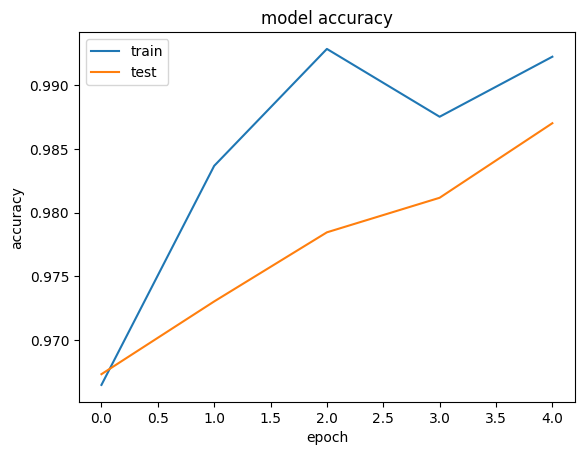

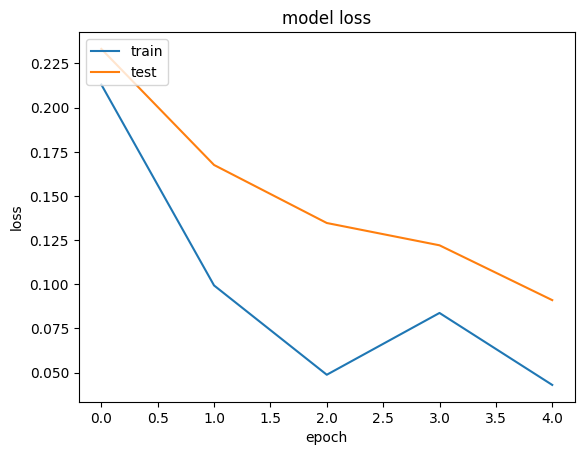

In [174]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
y_preds = model.predict(test_ds)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

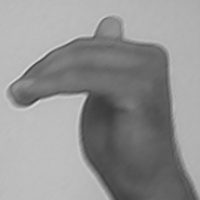

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0.]


In [150]:
output_image_from_array(X_test[0].reshape(200, 200))
print(test_labels[0])

In [78]:
model.evaluate(test_ds, test_labels)

183/183 [==============================] - 875s 5s/step - loss: 0.1488 - accuracy: 0.9735


[0.14882846176624298, 0.9734634757041931]

In [133]:
classes
classes_2 = {}
for letter in classes:
    classes_2[classes[letter]] = letter

In [154]:
classes_2

{1: 'л. I',
 2: 'л. Є',
 3: 'л. А',
 4: 'л. Б',
 5: 'л. В',
 6: 'л. Г',
 7: 'л. Е',
 8: 'л. Ж',
 9: 'л. З',
 10: 'л. И',
 11: 'л. К',
 12: 'л. Л',
 13: 'л. М',
 14: 'л. Н',
 15: 'л. О',
 16: 'л. П',
 17: 'л. Р',
 18: 'л. С',
 19: 'л. Т',
 20: 'л. У',
 21: 'л. Ф',
 22: 'л. Х',
 23: 'л. Ш',
 24: 'л. Ь',
 25: 'л. Ю',
 26: 'л. Я'}

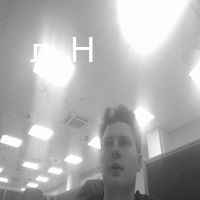

KeyboardInterrupt: 

In [169]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import ipywidgets as widgets
import threading
import IPython


def preprocess_img(image):
    img = Image.fromarray(image)
    img = np.array(img.resize(SIZE))

    img = tf.image.rgb_to_grayscale(np.array([img])).numpy()
    
    original = tf.constant(img)
    converted = tf.image.grayscale_to_rgb(original).numpy()
    
    return converted
    
def view():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    display_handle=display(None, display_id=True)
    i = 0
    while True:
        _, frame = cap.read()

        outcome_frame = preprocess_img(frame)
        
        y_pred = model(outcome_frame).numpy()
        y_classes = y_pred[0].argmax(axis=-1)
        letter = classes_2[y_classes]
        
        image = np.zeros((100, 950, 3), dtype=np.uint8)
        image = cv2.cvtColor(outcome_frame[0], cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image)

        # Draw non-ascii text onto image
        font = ImageFont.truetype("C:\Windows\Fonts\\arial.ttf", 35)
        draw = ImageDraw.Draw(pil_image)
        draw.text((30, 30), letter, font=font)

        # Convert back to Numpy array and switch back from RGB to BGR
        image = np.asarray(pil_image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


        _, frame = cv2.imencode('.jpeg', image)
        display_handle.update(IPython.display.Image(frame))

            
# Run
# ================
view()